In [1]:
# Libraries Import
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose
from tensorflow.compat.v1.keras.layers import BatchNormalization

# Ignore Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Search List of Images in Directory
def list_images(basePath):
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"))

# Search Files with Image Extensions
def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp")):
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        for filename in filenames:
            ext = filename[filename.rfind("."):].lower()
            if ext.endswith(validExts):
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
#Extract Image Files from the Kaggle Directory
def load_images(directory='', size=(64,64)):
    images = []
    labels = []
    label = 0
    imagePaths = list(list_images(directory))
    for path in imagePaths:
        path = path.replace('\\','/')
        image = cv2.imread(path) 
        image = cv2.resize(image,size)
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return images

In [3]:
# Load Images
images=load_images('../input/interior-design')

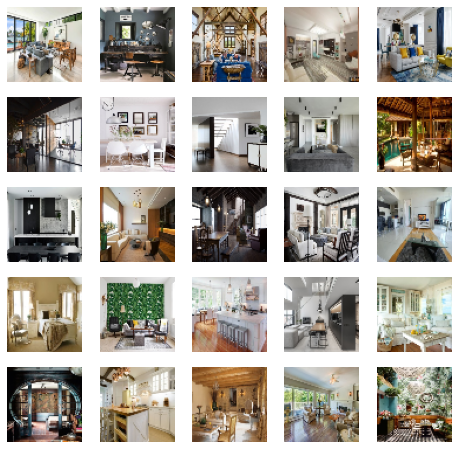

In [4]:
# Check Images by Plotting
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [5]:
# GAN Model
class GAN():
    # learning rate 0.0002, regularization 0.1
    # noise 100px random, loss binary cross
    # convolutional layer
    def __init__(self):
        self.img_shape = (64, 64, 3)
        self.noise_size = 100
        optimizer = Adam(0.0002,0.1)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        self.discriminator.trainable = False
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined.summary()
        
    # Generator Model
    # deconvolutional layer
    # leaky relu with neg slope 0.2
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(Activation("tanh"))
        
        model.summary()
        noise = Input(shape=noise_shape)
        img = model(noise)
        return Model(noise, img)

    # Discriminator Model
    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        print(validity.shape)
        print(img, validity)
        return Model(img, validity)

    # Training Model
    def train(self, epochs, batch_size=512, metrics_update=50, save_images=100, save_model=2000):
        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        half_batch = int(batch_size / 2)
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))
                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 100 images
            if epoch % save_images == 0:
                self.save_images(epoch)

            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Save Training Images into Desired File
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        fig.savefig("Interior/Rooms_%d.png" % epoch)
        plt.close()

In [ ]:
# Save Training In Interior Folder
!mkdir Interior

In [ ]:
# GAN Training Session
# batch size as [512, 1023]
# epochs as [15000, 20000, 8400]

gan=GAN()
gan.train(epochs=20001, batch_size=512, metrics_update=100, save_images=1000, save_model=20000)

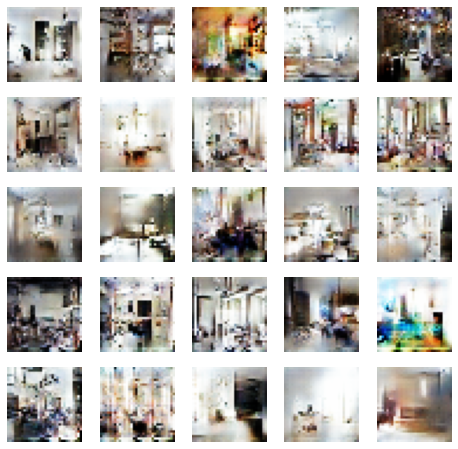

In [11]:
# Generate Interior Design Randomly
# Based on Trained Parameter in Generator
# Determine size, batch size, use generator
# to predict, display only 25 of the images

noise_size = 100
half_batch = 25
gan = load_model('/kaggle/input/result/results/generator_15000')
noise = np.random.normal(0, 1, (half_batch, noise_size))
gen_img = gan.predict(noise)
fig, axs = plt.subplots(5,5, figsize = (8,8))
gen_img = 0.5 * gen_img + 0.5

for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_img[5*i+j])
        axs[i,j].axis('off')

plt.show()